**LOAD THE PACKAGES**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Generate a toy dataset

In [2]:
num_families = 500
income = np.random.uniform(10000,100000,num_families)
num_children = np.random.randint(0,4,num_families)
house_mq_squares = np.random.randint(50,200,num_families)
age_of_head = np.random.randint(18,60,num_families)
educational_level = np.random.choice(['High School','Bachelors','Master','PhD'],num_families)
marital_status = np.random.choice(['Married','Single','Divorced','Widowes'],num_families)

In [3]:
print(np.max(income))

99945.35562902284


In [4]:
expenses_bas = income * 0.3 # basic expenses, 60 % of the salary
factor_house = (house_mq_squares - 50)/(149) # Normalize between 0 and 1
factor_age = (60 - age_of_head)/(60-18) # Normalize between 0 and 1
expenses_chd = income * (num_children * 0.05) # each children has an impact of 5%
expenses_hos = income * (factor_house * 0.5) # Maximum impact 20%
expenses_age = income * (factor_age * 0.15) # Maximum impact 10%
expenses = expenses_bas + expenses_chd + expenses_hos + expenses_age
expenses = expenses + np.random.normal(0,200,num_families) # add some noise
#print(np.max(factor_house)*0.1)

In [5]:
data = {'income':income,
        'num_children':num_children,
        'house_mq_squares':house_mq_squares,
        'age_of_head':age_of_head,
        'educational_level':educational_level,
        'marital_status':marital_status,
        'expenses':expenses}
df = pd.DataFrame(data)
print(df.head())
print(df.dtypes)

         income  num_children  house_mq_squares  age_of_head  \
0  80613.553059             3                87           42   
1  53435.710378             1                94           41   
2  16958.461584             0                62           25   
3  82461.293772             0               101           30   
4  55230.740004             3               185           28   

  educational_level marital_status      expenses  
0               PhD       Divorced  51476.697874  
1            Master       Divorced  30106.106380  
2       High School         Single   7881.720019  
3               PhD         Single  47607.424901  
4         Bachelors        Widowes  56012.441254  
income               float64
num_children           int64
house_mq_squares       int64
age_of_head            int64
educational_level     object
marital_status        object
expenses             float64
dtype: object


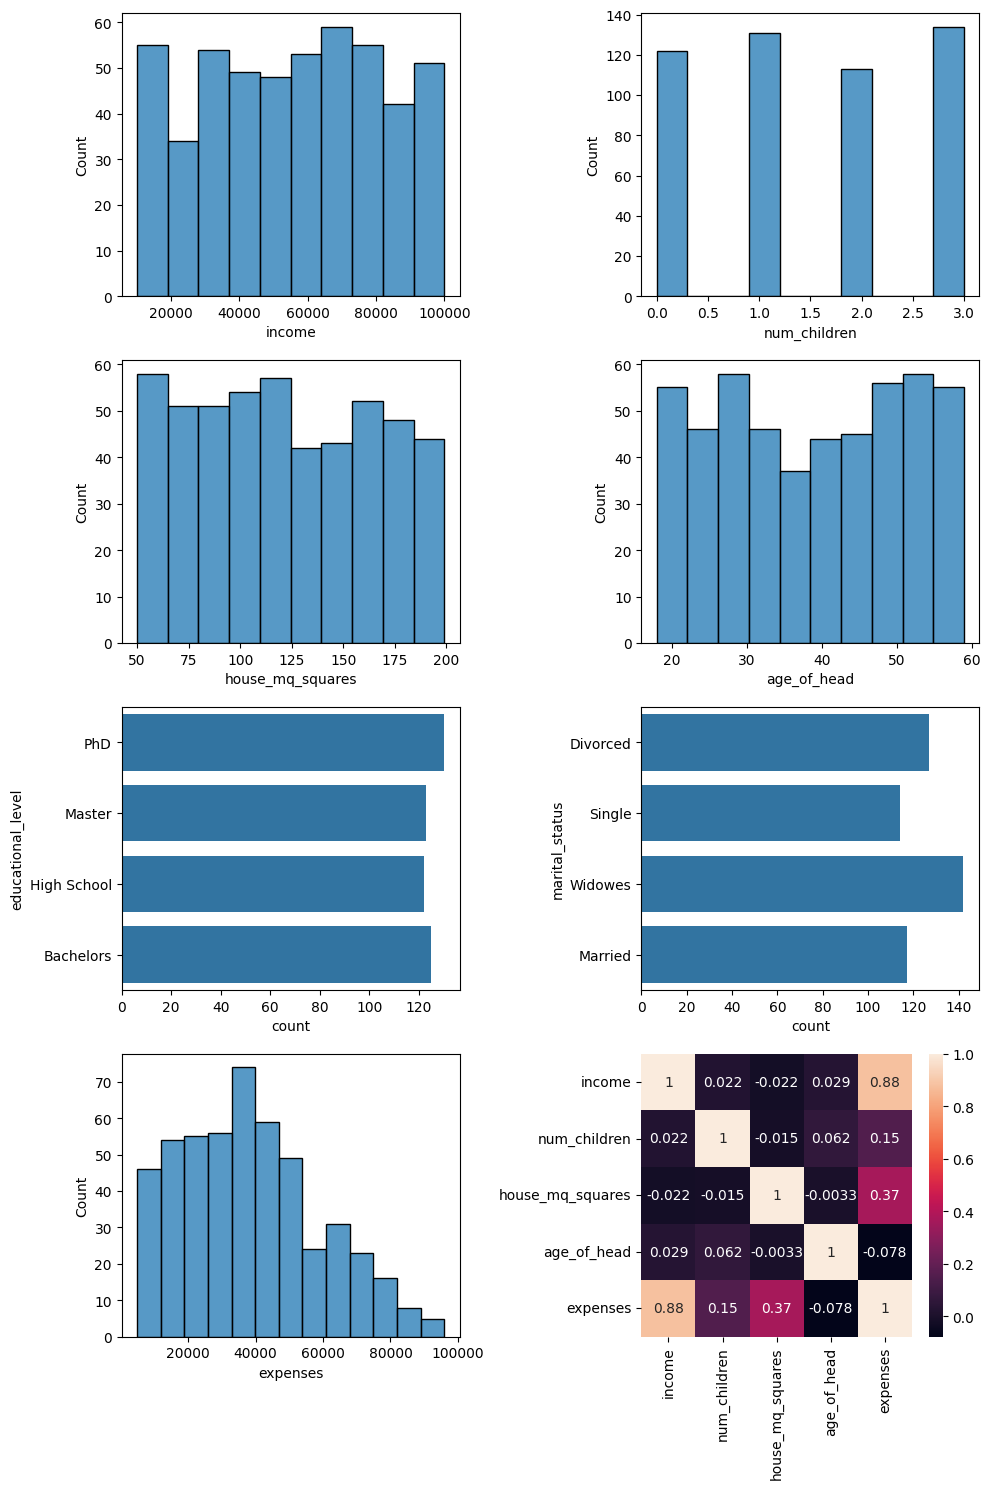

In [6]:
fig, axes = plt.subplots(4,2,figsize=(10,15))
axes = axes.flatten()
for i, col in enumerate(df.columns):
  if df[col].dtypes in ['float64','int64']:
    sns.histplot(df[col], ax = axes[i])
  else:
    sns.countplot(df[col], ax = axes[i])
sns.heatmap(df.corr(method='pearson', min_periods=1, numeric_only=True), annot=True, ax = axes[7])
plt.tight_layout()
plt.show()


In [7]:
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

In [8]:
x = df.drop('expenses',axis = 1)
y = df['expenses']

In [9]:
x_train, x_test, y_train, y_test = tts(x,
                                       y,
                                       test_size = 0.25)

In [10]:
prepro = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['income','num_children','house_mq_squares','age_of_head']),
        ('cat', OneHotEncoder(), ['educational_level','marital_status'])
    ],
)

In [11]:
rfr = RandomForestRegressor()
model = Pipeline([
    ('preprocessor',prepro),
    ('regressor',rfr)
])

In [12]:
parameters = {
    'regressor__n_estimators':[100,200,300],
    'regressor__max_depth':[None, 10, 20, 30],
    'regressor__min_samples_split':[2,5,10],
    'regressor__min_samples_leaf':[1,2,4]
}

gs = GSCV(
    estimator = model,
    param_grid = parameters,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    verbose = 1)

In [13]:
gs.fit(x_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['income',
                                                                          'num_children',
                                                                          'house_mq_squares',
                                                                          'age_of_head']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['educational_level',
                                                                          'marital_status'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [14]:
print("Best parameters:", gs.best_params_)
print(f'Best score:, {gs.best_score_:.3f}')

best_model = gs.best_estimator_
y_pred_train = best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)

mae_train = mae(y_train,y_pred_train)
mse_train = mse(y_train,y_pred_train)
r2_train = r2(y_train,y_pred_train)

mae_test = mae(y_test,y_pred_test)
mse_test = mse(y_test,y_pred_test)
r2_test = r2(y_test, y_pred_test )

Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best score:, -10540551.939


In [15]:
print(f'Train mae: {mae_train:.3f} - Train mse: {mse_train:.3f} - R2 train: {r2_train:.3f}')
print(f'Test mae: {mae_test:.3f} - Test mse: {mse_test:.3f} - R2 test: {r2_test:.3f}')

Train mae: 943.270 - Train mse: 1542155.997 - R2 train: 0.996
Test mae: 2706.803 - Test mse: 12422278.350 - R2 test: 0.973


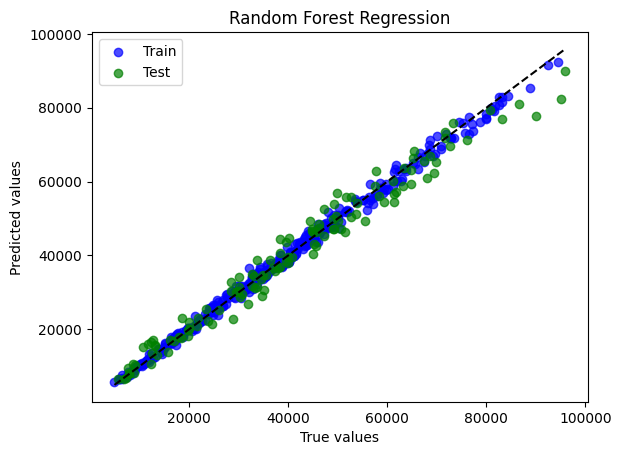

In [16]:
plt.scatter(y_train,y_pred_train,label='Train',color='blue',alpha=0.7)
plt.scatter(y_test,y_pred_test,label='Test',color='green',alpha = 0.7)
plt.plot([min(y), max(y)],[min(y), max(y)],linestyle='--',color='black')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Random Forest Regression')
plt.legend()
plt.show()

# **USING ADABOOST**

In [18]:
from sklearn.ensemble import AdaBoostRegressor

# Define the AdaBoost Regressor
abr = AdaBoostRegressor()

# Update the pipeline
model = Pipeline([
    ('preprocessor', prepro),
    ('regressor', abr)
])

# Define the parameter grid for AdaBoost
parameters = {
    'regressor__n_estimators': [50, 100, 200],  # Number of weak learners
    'regressor__learning_rate': [0.01, 0.1, 1.0],  # Learning rate
    'regressor__loss': ['linear', 'square', 'exponential']  # Loss function
}

# Grid Search
gs = GSCV(
    estimator=model,
    param_grid=parameters,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

# Fit the model
gs.fit(x_train, y_train)

# Print the best parameters and score
print("Best parameters:", gs.best_params_)
print(f"Best score: {gs.best_score_:.3f}")

# Evaluate the best model
best_model = gs.best_estimator_
y_pred_train = best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)

# Calculate metrics
mae_train = mae(y_train, y_pred_train)
mse_train = mse(y_train, y_pred_train)
r2_train = r2(y_train, y_pred_train)

mae_test = mae(y_test, y_pred_test)
mse_test = mse(y_test, y_pred_test)
r2_test = r2(y_test, y_pred_test)

# Print the metrics
print("\nTraining Metrics:")
print(f"  Mean Absolute Error (MAE): {mae_train:.2f}")
print(f"  Mean Squared Error (MSE): {mse_train:.2f}")
print(f"  R² Score: {r2_train:.2f}")

print("\nTest Metrics:")
print(f"  Mean Absolute Error (MAE): {mae_test:.2f}")
print(f"  Mean Squared Error (MSE): {mse_test:.2f}")
print(f"  R² Score: {r2_test:.2f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'regressor__learning_rate': 1.0, 'regressor__loss': 'square', 'regressor__n_estimators': 100}
Best score: -19084330.548

Training Metrics:
  Mean Absolute Error (MAE): 3072.07
  Mean Squared Error (MSE): 14275935.35
  R² Score: 0.96

Test Metrics:
  Mean Absolute Error (MAE): 4064.80
  Mean Squared Error (MSE): 25140814.06
  R² Score: 0.94


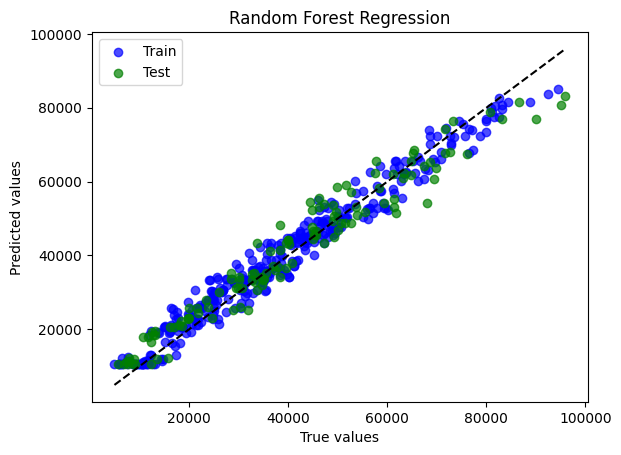

In [19]:
plt.scatter(y_train,y_pred_train,label='Train',color='blue',alpha=0.7)
plt.scatter(y_test,y_pred_test,label='Test',color='green',alpha = 0.7)
plt.plot([min(y), max(y)],[min(y), max(y)],linestyle='--',color='black')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Random Forest Regression')
plt.legend()
plt.show()

# **USING ANN MODEL**

In [ ]:
 # import the supplementary packages

In [ ]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
x_train, x_test, y_train, y_test = tts(x,
                                      y,
                                      test_size = 0.25)

In [ ]:
# Preprocess the x
x_train = prepro.fit_transform(x_train)
x_test = prepro.transform(x_test)

In [ ]:
# Build the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
ann = model.fit(x_train,
                y_train,
                epochs=100,
                batch_size=64,
                validation_split=0.2,
                callbacks=[early_stop],
                verbose = 1)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 2080494720.0000 - mae: 39884.5586 - val_loss: 2368930560.0000 - val_mae: 42674.1914
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2190226688.0000 - mae: 41151.2773 - val_loss: 2368880896.0000 - val_mae: 42673.6094
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2234409216.0000 - mae: 41893.0664 - val_loss: 2368808448.0000 - val_mae: 42672.7656
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2216225024.0000 - mae: 40648.2617 - val_loss: 2368699904.0000 - val_mae: 42671.5273
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2166494464.0000 - mae: 40991.3203 - val_loss: 2368539392.0000 - val_mae: 42669.6953
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2164460032.0000 - mae: 40773.7969 - val_loss: 2368296704.0000 - val_mae: 42666.9570
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2154381312.0000 - mae: 40524.3594 - val_loss: 2367930368.0000 - val_mae: 42662.8398
Epoch 

In [ ]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

mae_train = mae(y_train,y_pred_train)
mse_train = mse(y_train,y_pred_train)
r2_train = r2(y_train,y_pred_train)

mae_test = mae(y_test,y_pred_test)
mse_test = mse(y_test,y_pred_test)
r2_test = r2(y_test, y_pred_test )

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
print(f'Train mae: {mae_train:.3f} - Train mse: {mse_train:.3f} - R2 train: {r2_train:.3f}')
print(f'Test mae: {mae_test:.3f} - Test mse: {mse_test:.3f} - R2 test: {r2_test:.3f}')

Train mae: 7897.710 - Train mse: 102250334.481 - R2 train: 0.806
Test mae: 7696.590 - Test mse: 96852274.998 - R2 test: 0.819


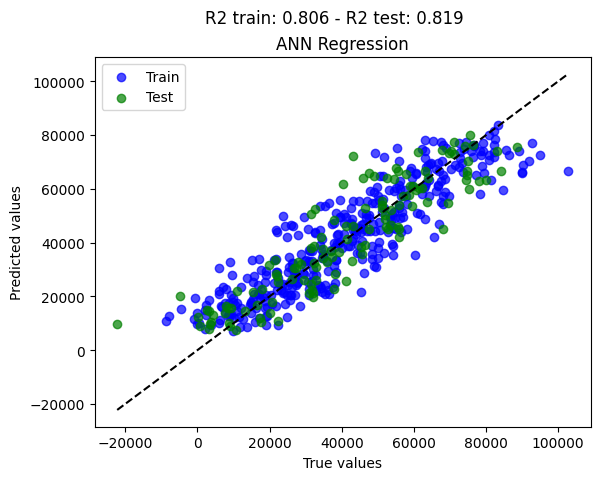

In [ ]:
plt.scatter(y_train, y_pred_train, label='Train', color='blue', alpha=0.7)
plt.scatter(y_test, y_pred_test, label='Test', color='green', alpha = 0.7)
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='black')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('ANN Regression')
plt.suptitle('R2 train: {:.3f} - R2 test: {:.3f}'.format(r2_train, r2_test))
plt.legend()